# Image registration plugin

Create a plugin to register two images enabling users to choose from various algorithms 
1) Read in two images
2) Select registration algorithm
3) Warp moving image by modifying metadata of image layer
4) Display result in napari viewer


In [1]:
from skimage import data
import numpy as np
from scipy import ndimage

import napari
from magicgui import magicgui

## Load sample data

In [2]:
IMAGE2D = data.cells3d()[30,1]

trafo_matrix = np.eye(3)
trafo_matrix[0,2] = -22.4
trafo_matrix[1,2] = 13.2    

inv_mat = np.linalg.inv(trafo_matrix)
IMAGE2D_offset = ndimage.affine_transform(input=IMAGE2D,
                                          matrix=inv_mat,
                                          output_shape=IMAGE2D.shape,
                                          order=2)

## Magicgui Implementation

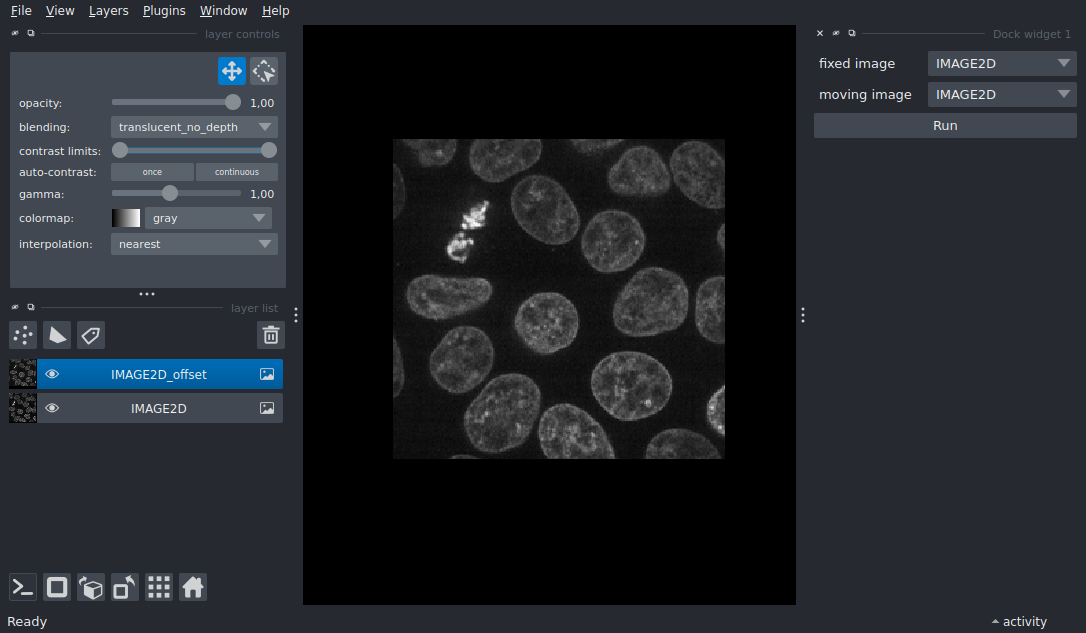

In [3]:
@magicgui
def register_images(
    fixed_image: 'napari.layers.Image', 
    moving_image: 'napari.layers.Image'
) -> 'napari.layers.Image':
    
    from skimage.registration import phase_cross_correlation 
    from napari.layers import Image

    shift, __, __ = phase_cross_correlation(fixed_image.data, moving_image.data)

    trafo_matrix = np.eye(3)
    trafo_matrix[0,2] = shift[0]
    trafo_matrix[1,2] = shift[1]
    
    warped_image_data = moving_image.data.copy()
    warped_image = Image(warped_image_data)
    warped_image.affine.affine_matrix = trafo_matrix
    warped_image.name = moving_image.name + '_warped'
    
    return warped_image

viewer = napari.view_image(IMAGE2D)
viewer.add_image(IMAGE2D_offset)
viewer.window.add_dock_widget(register_images)
napari.utils.nbscreenshot(viewer)

## Magic Factory Implementation

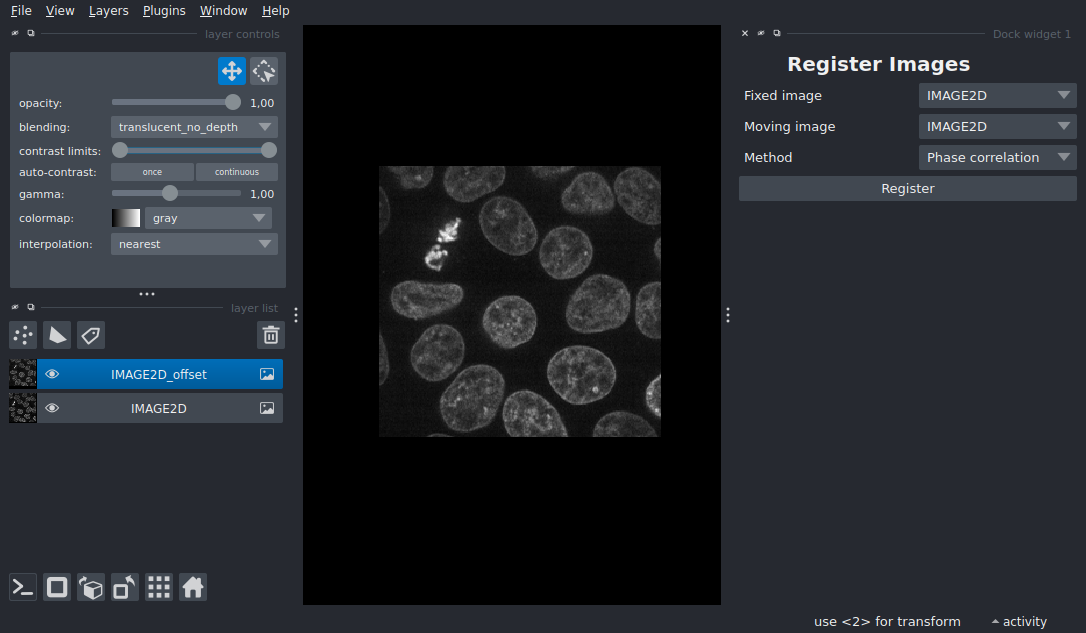

In [6]:
from magicgui import magic_factory   

@magic_factory(
    layout='vertical', call_button='Register',
    widget_header={'widget_type': 'Label',
                   'label': f'<h2 text-align="left">Register Images</h2>'},
    fixed_image={'label': 'Fixed image'},
    moving_image={'label': 'Moving image'},
    registration_method={'label': 'Method',
                         'widget_type': 'ComboBox',
                         'choices': ['Phase correlation', 'Optical flow'],
                         'value': 'Phase correlation'},
)
def register_images(
    viewer: 'napari.viewer.Viewer',
    widget_header,
    fixed_image: 'napari.layers.Image',
    moving_image: 'napari.layers.Image',
    registration_method
):
    from skimage.registration import phase_cross_correlation, optical_flow_tvl1
    from skimage.color import rgb2gray
    from skimage.transform import warp
    from napari.layers import Image

    if registration_method == 'Phase correlation':
        shift, __, __ = phase_cross_correlation(fixed_image.data, moving_image.data)
    
        trafo_matrix = np.eye(3)
        trafo_matrix[0,2] = shift[0]
        trafo_matrix[1,2] = shift[1]
        
        warped_image_data = moving_image.data.copy()
        warped_image = Image(warped_image_data)
        warped_image.affine.affine_matrix = trafo_matrix
        warped_image.name = moving_image.name + '_warped'
    
        viewer.add_layer(warped_image)
        
    elif registration_method == 'Optical flow':
        moving = moving_image.data
        fixed = fixed_image.data
        
        v, u = optical_flow_tvl1(fixed, moving)
        h, w = fixed.shape
        row_coords, col_coords = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
        moving_warped = warp(moving, np.array([row_coords + v, col_coords + u]), mode='edge')
        
        warped_image = Image(moving_warped)
        warped_image.name = moving_image.name + '_warped'

        vector_list = []
        for i, (v_, u_, r_, c_) in enumerate(zip(v.ravel(), u.ravel(), row_coords.ravel(), col_coords.ravel())):
            if i % 100 == 0:
                vector_list.append([[r_, c_], [-v_, -u_]])

        optical_flow_vectors = np.asarray(vector_list)
        viewer.add_layer(warped_image)
        viewer.add_vectors(optical_flow_vectors, name='Optical flow', vector_style='arrow', length=0.25)
        
viewer = napari.view_image(IMAGE2D)
viewer.add_image(IMAGE2D_offset)
widget = register_images()
viewer.window.add_dock_widget(widget)
napari.utils.nbscreenshot(viewer)